In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
total_instruments = 5
trial_length = 100 # 1000ms
dt = 1 # time interval/step to run differential equation
total_trials = 10
test_trials = [1,5,10]

In [3]:
# define dataset
def generate_audio_data(instrument,total_instruments, length=1,dt=1, seed=0):
    # length is in seconds
    # timestep is in ms
    T = length*1000//dt
    np.random.seed(seed)
    I = np.random.normal(size=(T, total_instruments))
    I[:,instrument] += np.random.normal(loc=2, scale=0.5,size=(T))
    return I



In [4]:
num_eeg_channels = 78


In [5]:
class Pseudo_Brain_EEG:
    def __init__(self,audio_size,brain_size=1000, eeg_channels=78):
        self.brain_size = brain_size
        self.eeg_channels = eeg_channels
        self.brain_matrix = np.random.normal(size=(brain_size,audio_size)) * 0.1
        self.eeg_matrix = np.random.normal(size=(eeg_channels, brain_size)) * 0.1

    def get_eeg_activity(self, audio_x):
        # get brain activity 
        brain = np.tanh(np.dot(self.brain_matrix, audio_x)) # scale between -1 to 1
        # get eeg activity
        eeg = np.tanh(np.dot(self.eeg_matrix, brain)) # cale between -1,1
        return eeg

eeg_func = Pseudo_Brain_EEG(audio_size=total_instruments, eeg_channels=num_eeg_channels)

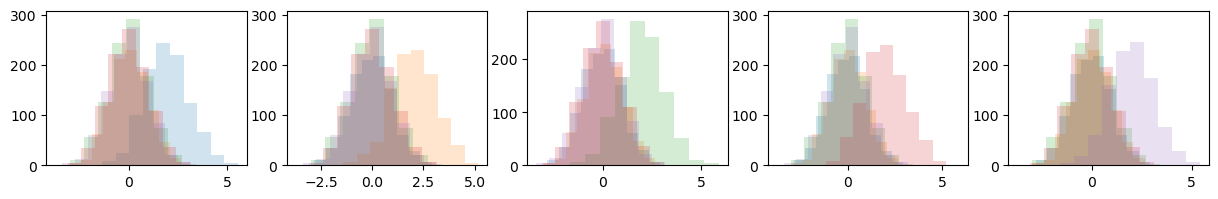

In [6]:
# plot difference in data distribution

f,ax = plt.subplots(1,5,figsize=(3*5,2))
for instrument_cls in range(total_instruments):
    data = generate_audio_data(instrument_cls, total_instruments)
    
    for d in range(total_instruments):
        ax[instrument_cls].hist(data[:,d],alpha=0.2)


In [7]:
# define reservoir computing model
# References: http://www.scholarpedia.org/article/Echo_state_network, Hoerzer et al. 2014 Cerebral Cortex; Kumar et al. 2022 Cerebral Cortex

In [8]:
class ReservoirComputingNetwork:
    def __init__(self, input_size, reservoir_size, output_size, chaos=1.2, tau=10, dt=1, learning_rate=0.001):
        self.tau = tau  # time constant
        self.alpha = dt/self.tau
        self.nin = input_size
        self.nrnn = reservoir_size
        self.nout = output_size
        self.cp = [1,0.1]  #connection probability
        self.lr = learning_rate
        
        # Initialize weights
        self.w_in = np.random.rand(reservoir_size, input_size) 
        self.w_rec = np.random.rand(reservoir_size, reservoir_size) 

        winconn = np.random.uniform(-1, 1, (self.nrnn, self.nin))  # uniform dist [-1,1]
        winprob = np.random.choice([0, 1], (self.nrnn, self.nin), p=[1 - self.cp[0], self.cp[0]])
        self.w_in = np.multiply(winconn, winprob) # cater to different input connection probabilities

        connex = np.random.normal(0, np.sqrt(1 / (self.cp[1] * self.nrnn)), size=(self.nrnn, self.nrnn))
        prob = np.random.choice([0, 1], (self.nrnn, self.nrnn), p=[1 - self.cp[1], self.cp[1]])
        w_rec = chaos * np.multiply(connex, prob)  # initialise random network with connection probability
        w_rec *= (np.eye(self.nrnn) == 0)  # remove self recurrence
        self.w_rec = w_rec

        self.w_fb = np.random.uniform(-1, 1, (self.nrnn, self.nout)) 
        
        self.w_out = np.random.rand(output_size, reservoir_size) * 1/reservoir_size

    def reset(self,trial):
        np.random.seed(trial)
        self.state = np.random.rand(self.nrnn)*0.1
        self.output = np.random.rand(self.nout)*0.1

    
    def run(self, input_vector):
        # Update reservoir state using leaky integrator rule
        I = np.dot(self.w_in, input_vector)
        h = np.dot(self.w_rec, self.state)
        fb = np.dot(self.w_fb, self.output)
        self.state = (1.0 - self.alpha) * self.state + self.alpha * np.tanh(I + h + fb)
        
        # Compute output
        self.output = np.dot(self.w_out, self.state)
        return self.output
    
    def learn(self, predicted_output,target_output):
        # Simple delta rule (Gradient descent on the output weights)
        # Run network to get current output
        self.error = target_output - predicted_output
        
        # Update the output weights using the delta rule
        self.w_out += self.lr * np.outer(self.error, self.state)
        return self.error

In [9]:
ninputs = num_eeg_channels
nrnn = 1024
noutputs = total_instruments
tau = 50
chaos = 1.2
lr = 0.0001
reservoir = ReservoirComputingNetwork(input_size=ninputs, reservoir_size=nrnn, output_size=noutputs,chaos=chaos, tau=tau,learning_rate=lr)
init_wout = reservoir.w_out.copy()

In [10]:
record_output = np.zeros([total_trials, total_instruments, trial_length, noutputs])
record_error = np.zeros([total_trials, total_instruments, trial_length, noutputs])



for trial in range(total_trials):
    instrument_cls = np.random.choice(np.arange(total_instruments),total_instruments, replace=False)

    for i, instrument in enumerate(instrument_cls):

        audio_data = generate_audio_data(instrument, total_instruments)
        ground_truth = np.zeros(total_instruments)
        ground_truth[instrument] = 1
        reservoir.reset(trial)
        
        print(f'Trial {trial}, Instrument {instrument}')
        for time in range(trial_length):
            x = data[time]

            # get eeg data
            x_eeg = eeg_func.get_eeg_activity(x)

            # predict classifier output
            pred = reservoir.run(x_eeg)

            # online learning to classify , if trial is in test_trials, do not change classifier weights/learn
            if trial+1 not in test_trials:
                error = reservoir.learn(pred, ground_truth)

            record_output[trial, instrument, time] = pred
            record_error[trial, instrument, time] = ground_truth - pred

Trial 0, Instrument 2
Trial 0, Instrument 4
Trial 0, Instrument 3
Trial 0, Instrument 0
Trial 0, Instrument 1
Trial 1, Instrument 2
Trial 1, Instrument 4
Trial 1, Instrument 3
Trial 1, Instrument 0
Trial 1, Instrument 1
Trial 2, Instrument 0
Trial 2, Instrument 2
Trial 2, Instrument 1
Trial 2, Instrument 4
Trial 2, Instrument 3
Trial 3, Instrument 0
Trial 3, Instrument 2
Trial 3, Instrument 1
Trial 3, Instrument 4
Trial 3, Instrument 3
Trial 4, Instrument 4
Trial 4, Instrument 2
Trial 4, Instrument 0
Trial 4, Instrument 3
Trial 4, Instrument 1
Trial 5, Instrument 1
Trial 5, Instrument 0
Trial 5, Instrument 4
Trial 5, Instrument 2
Trial 5, Instrument 3
Trial 6, Instrument 0
Trial 6, Instrument 2
Trial 6, Instrument 1
Trial 6, Instrument 4
Trial 6, Instrument 3
Trial 7, Instrument 0
Trial 7, Instrument 4
Trial 7, Instrument 2
Trial 7, Instrument 3
Trial 7, Instrument 1
Trial 8, Instrument 1
Trial 8, Instrument 2
Trial 8, Instrument 3
Trial 8, Instrument 4
Trial 8, Instrument 0
Trial 9, I

Text(0, 0.5, 'Error')

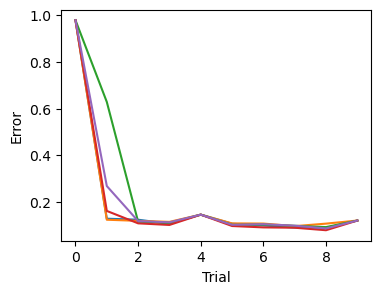

In [12]:
plt.figure(figsize=(4,3))
plt.plot(np.mean(np.sum(record_error,axis=3),axis=2))
plt.xlabel('Trial')
plt.ylabel('Error')


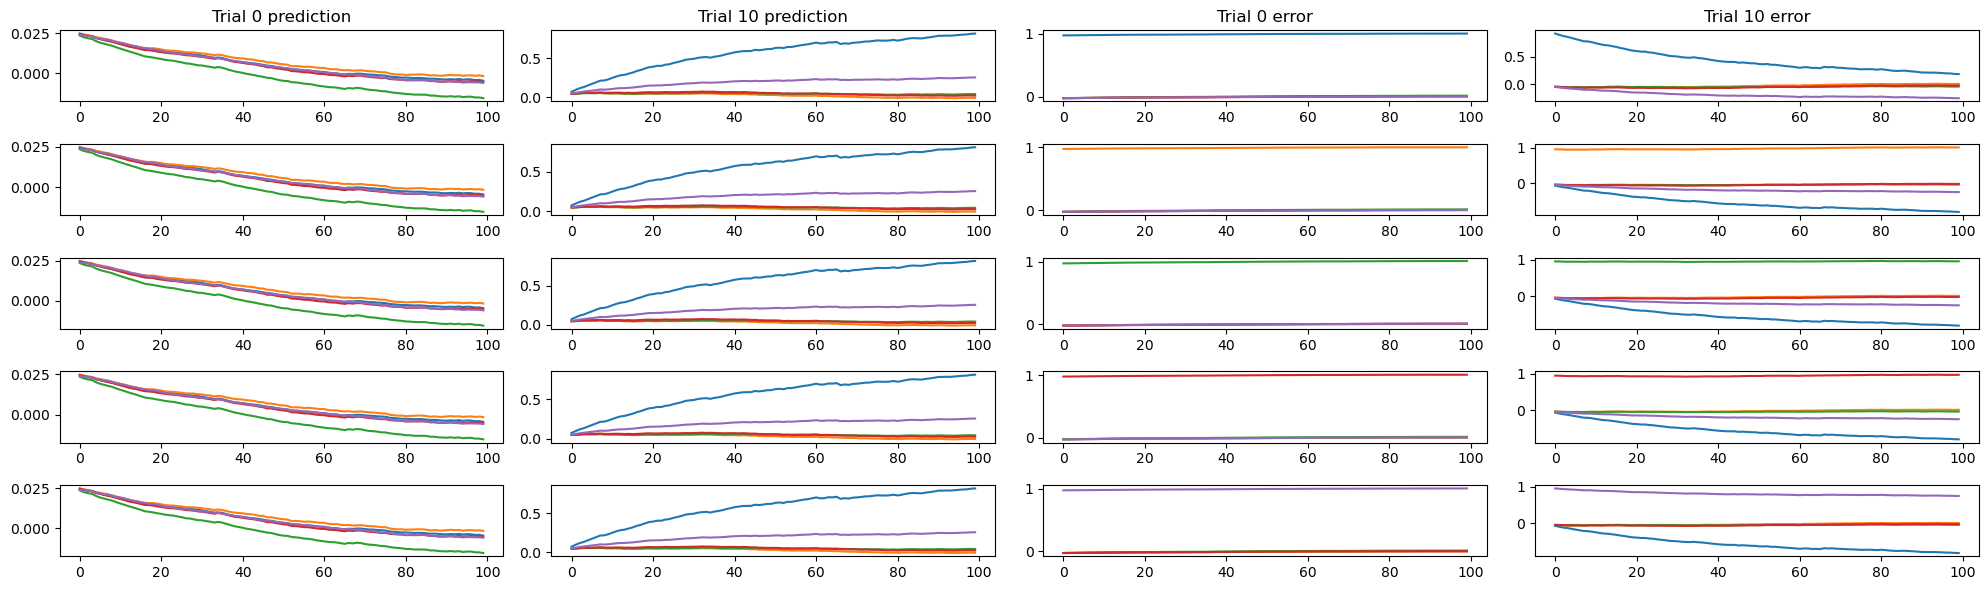

In [13]:
instrument = 2

f,ax = plt.subplots(total_instruments,4,figsize=(4*total_instruments,3*2))

for instrument in range(total_instruments):
    ax[instrument, 0].plot(record_output[0,instrument])

    ax[instrument, 1].plot(record_output[-1,instrument])

    ax[instrument, 2].plot(record_error[0,instrument])

    ax[instrument, 3].plot(record_error[-1,instrument])

ax[0,0].set_title('Trial 0 prediction')
ax[0,1].set_title(f'Trial {total_trials} prediction')

ax[0,2].set_title('Trial 0 error')
ax[0,3].set_title(f'Trial {total_trials} error')

f.tight_layout()

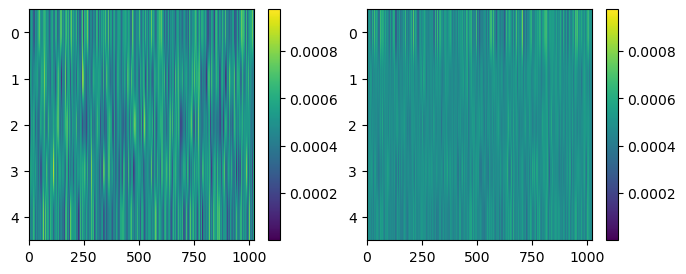

In [14]:
f,ax = plt.subplots(1,2,figsize=(4*2,3))

im = ax[0].imshow(init_wout,aspect='auto')
plt.colorbar(im,ax=ax[0])
im2 = ax[1].imshow(reservoir.w_out,aspect='auto')
plt.colorbar(im,ax=ax[1])